# Importacion de librerias

In [1]:
# Importacion de librerias
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

In [2]:
# interactive mode
plt.ion() 

# Lectura de datos

In [3]:
# Data augmentation and normalization for training
# Just normalization for validation

data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((230,230)),
        transforms.RandomRotation(15,),
        transforms.RandomCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.507, 0.487, 0.441], std=[0.267, 0.256, 0.276])
    ]),
    'val': transforms.Compose([
        #transforms.Resize(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.507, 0.487, 0.441], std=[0.267, 0.256, 0.276])
    ]),
    'test': transforms.Compose([
        #transforms.Resize(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.507, 0.487, 0.441], std=[0.267, 0.256, 0.276])
    ]),
}

In [4]:
#install kaggle
!pip install -q kaggle

In [ ]:
from google.colab import files 
files.upload()

In [6]:
#create a kaggle folder
!mkdir ~/.kaggle

In [7]:
#copy the kaggle.json to folder created
!cp kaggle.json ~/.kaggle/

In [8]:
#Permission for the json to act 
!chmod 600 ~/.kaggle/kaggle.json

In [9]:
#To list all datasets in kaggle
!kaggle datasets list

ref                                                         title                                              size  lastUpdated          downloadCount  
----------------------------------------------------------  ------------------------------------------------  -----  -------------------  -------------  
gpreda/reddit-vaccine-myths                                 Reddit Vaccine Myths                              229KB  2021-06-09 12:09:58           7133  
crowww/a-large-scale-fish-dataset                           A Large Scale Fish Dataset                          3GB  2021-04-28 17:03:01           4324  
imsparsh/musicnet-dataset                                   MusicNet Dataset                                   22GB  2021-02-18 14:12:19           1443  
mathurinache/twitter-edge-nodes                             Twitter Edge Nodes                                342MB  2021-03-08 06:43:04            477  
fatiimaezzahra/famous-iconic-women                          Famous Iconic Wo

In [10]:
!kaggle datasets download -d gpiosenka/100-bird-species

100% 889M/889M [00:05<00:00, 196MB/s]
100% 889M/889M [00:06<00:00, 155MB/s]


In [11]:
!unzip 100-bird-species.zip

Se han truncado las últimas 5000 líneas del flujo de salida.
  inflating: train/TOWNSENDS WARBLER/091.jpg  
  inflating: train/TOWNSENDS WARBLER/092.jpg  
  inflating: train/TOWNSENDS WARBLER/093.jpg  
  inflating: train/TOWNSENDS WARBLER/094.jpg  
  inflating: train/TOWNSENDS WARBLER/095.jpg  
  inflating: train/TOWNSENDS WARBLER/096.jpg  
  inflating: train/TOWNSENDS WARBLER/097.jpg  
  inflating: train/TOWNSENDS WARBLER/098.jpg  
  inflating: train/TOWNSENDS WARBLER/099.jpg  
  inflating: train/TOWNSENDS WARBLER/100.jpg  
  inflating: train/TOWNSENDS WARBLER/101.jpg  
  inflating: train/TOWNSENDS WARBLER/102.jpg  
  inflating: train/TOWNSENDS WARBLER/103.jpg  
  inflating: train/TOWNSENDS WARBLER/104.jpg  
  inflating: train/TOWNSENDS WARBLER/105.jpg  
  inflating: train/TOWNSENDS WARBLER/106.jpg  
  inflating: train/TOWNSENDS WARBLER/107.jpg  
  inflating: train/TOWNSENDS WARBLER/108.jpg  
  inflating: train/TOWNSENDS WARBLER/109.jpg  
  inflating: train/TOWNSENDS WARBLER/110.jpg  

In [12]:
!mv /content/valid /content/val

In [13]:
%ls

100-bird-species.zip  birds.csv  kaggle.json  sample_data/  test/  train/  val/


In [14]:
#Cortar los datos a la mitad:
import os 
from os import listdir
from os.path import join, isfile
from random import sample 

path = "/content/train"
for directory in listdir(path):
  images_path = path + "/" + directory
  temporal = list()

  for filename in listdir(images_path):
    filename = join(images_path, filename)

    if isfile(filename):
      temporal.append(filename)
  new_list = sample(temporal,len(temporal)//2)
  for path_rmv in new_list:
    os.remove(path_rmv)

In [15]:
data_dir = '/content'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val', 'test']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=24,
                                             shuffle=True, num_workers=0)
              for x in ['train', 'val', 'test']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val', 'test']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


In [16]:
len(dataloaders["train"])

824

In [17]:
# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

In [18]:
# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

In [19]:
image_datasets

{'test': Dataset ImageFolder
     Number of datapoints: 1375
     Root location: /content/test
     StandardTransform
 Transform: Compose(
                ToTensor()
                Normalize(mean=[0.507, 0.487, 0.441], std=[0.267, 0.256, 0.276])
            ), 'train': Dataset ImageFolder
     Number of datapoints: 19755
     Root location: /content/train
     StandardTransform
 Transform: Compose(
                Resize(size=(230, 230), interpolation=bilinear)
                RandomRotation(degrees=[-15.0, 15.0], interpolation=nearest, expand=False, fill=0)
                RandomCrop(size=(224, 224), padding=None)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
                Normalize(mean=[0.507, 0.487, 0.441], std=[0.267, 0.256, 0.276])
            ), 'val': Dataset ImageFolder
     Number of datapoints: 1375
     Root location: /content/val
     StandardTransform
 Transform: Compose(
                ToTensor()
                Normalize(mean=[0.507, 0.487, 

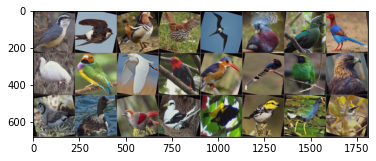

In [20]:
imshow(out)#, title=[class_names[x] for x in classes])

# Modelo

In [21]:
#Transfer learning
from torchsummary import summary
model_ft = models.wide_resnet101_2(pretrained=True)

for parameter in model_ft.parameters():
  parameter.requires_grad = False
summary(model_ft, (3, 224, 224),device="cpu")
num_ftrs = model_ft.fc.in_features
# model_ft = models.vgg19_bn(pretrained=True)
# num_ftrs = model_ft.classifier[0].in_features

Downloading: "https://download.pytorch.org/models/wide_resnet101_2-32ee1156.pth" to /root/.cache/torch/hub/checkpoints/wide_resnet101_2-32ee1156.pth



----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5          [-1, 128, 56, 56]           8,192
       BatchNorm2d-6          [-1, 128, 56, 56]             256
              ReLU-7          [-1, 128, 56, 56]               0
            Conv2d-8          [-1, 128, 56, 56]         147,456
       BatchNorm2d-9          [-1, 128, 56, 56]             256
             ReLU-10          [-1, 128, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          32,768
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14          [-1, 256

In [22]:
half_in_size = round(num_ftrs/2)
layer_width = 1024
Num_class=275

class SpinalNet(nn.Module):
    def __init__(self):
        super(SpinalNet, self).__init__()
        
        self.fc_spinal_layer1 = nn.Sequential(
            nn.Dropout(p = 0.5), nn.Linear(half_in_size, layer_width),
            nn.BatchNorm1d(layer_width), nn.ReLU(inplace=True),)
        self.fc_spinal_layer2 = nn.Sequential(
            nn.Dropout(p = 0.5), nn.Linear(half_in_size+layer_width, layer_width),
            nn.BatchNorm1d(layer_width), nn.ReLU(inplace=True),)
        self.fc_spinal_layer3 = nn.Sequential(
            nn.Dropout(p = 0.5), nn.Linear(half_in_size+layer_width, layer_width),
            nn.BatchNorm1d(layer_width), nn.ReLU(inplace=True),)
        self.fc_spinal_layer4 = nn.Sequential(
            nn.Dropout(p = 0.5), nn.Linear(half_in_size+layer_width, layer_width),
            nn.BatchNorm1d(layer_width), nn.ReLU(inplace=True),)
        self.fc_out = nn.Sequential(
            nn.Dropout(p = 0.5), nn.Linear(layer_width*4, Num_class),)
        
        

    def forward(self, x):
        x1 = self.fc_spinal_layer1(x[:, 0:half_in_size])
        x2 = self.fc_spinal_layer2(torch.cat([ x[:,half_in_size:2*half_in_size], x1], dim=1))
        x3 = self.fc_spinal_layer3(torch.cat([ x[:,0:half_in_size], x2], dim=1))
        x4 = self.fc_spinal_layer4(torch.cat([ x[:,half_in_size:2*half_in_size], x3], dim=1))
        
        
        x = torch.cat([x1, x2], dim=1)
        x = torch.cat([x, x3], dim=1)
        x = torch.cat([x, x4], dim=1)

        
        x = self.fc_out(x)
        return x



net_fc = nn.Sequential(
            nn.Linear(512, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, Num_class)
        )

# Entrenamiento

In [23]:
from tqdm.notebook import tqdm
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    train_losses = []
    val_losses = []

    train_accuracies = []
    val_accuracies = []  

    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    test_token=0

    for epoch in tqdm(range(num_epochs)):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val', 'test']:
             
            
            '''
            Test when a better validation result is found
            '''
            if test_token ==0 and phase == 'test':
                continue
            test_token =0
            
            
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            # cont = 0
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                test_token =1

            # copy the epoch's losses and accuracies
            if phase == 'train': 
                train_losses.append(epoch_loss)
                train_accuracies.append(epoch_acc)
            if phase == 'val': 
                val_losses.append(epoch_loss)
                val_accuracies.append(epoch_acc)

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, train_losses, val_losses, train_accuracies, val_accuracies


In [24]:
model_ft.fc = SpinalNet()
summary(model_ft, (3, 224, 224),device="cpu")

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5          [-1, 128, 56, 56]           8,192
       BatchNorm2d-6          [-1, 128, 56, 56]             256
              ReLU-7          [-1, 128, 56, 56]               0
            Conv2d-8          [-1, 128, 56, 56]         147,456
       BatchNorm2d-9          [-1, 128, 56, 56]             256
             ReLU-10          [-1, 128, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          32,768
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14          [-1, 256,

In [25]:
'''
Changing the fully connected layer to SpinalNet
'''

#model_ft.fc = nn.Linear(num_ftrs, 10)


model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

model_ft, train_losses, val_losses, train_accuracies, val_accuracies = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=10)

Epoch 0/9
----------
train Loss: 5.0436 Acc: 0.0822
val Loss: 3.7004 Acc: 0.3505
test Loss: 3.6735 Acc: 0.3345
Epoch 1/9
----------
train Loss: 3.4150 Acc: 0.2931
val Loss: 2.1572 Acc: 0.5527
test Loss: 2.1093 Acc: 0.5615
Epoch 2/9
----------
train Loss: 2.4791 Acc: 0.4418
val Loss: 1.4564 Acc: 0.6691
test Loss: 1.3974 Acc: 0.6975
Epoch 3/9
----------
train Loss: 2.0196 Acc: 0.5221
val Loss: 1.1113 Acc: 0.7287
test Loss: 1.0466 Acc: 0.7520
Epoch 4/9
----------
train Loss: 1.7535 Acc: 0.5689
val Loss: 1.0440 Acc: 0.7549
test Loss: 0.9673 Acc: 0.7745
Epoch 5/9
----------
train Loss: 1.5871 Acc: 0.5992
val Loss: 0.8061 Acc: 0.7869
test Loss: 0.7460 Acc: 0.8058
Epoch 6/9
----------
train Loss: 1.4632 Acc: 0.6252
val Loss: 0.8237 Acc: 0.8051
test Loss: 0.7482 Acc: 0.8218
Epoch 7/9
----------
train Loss: 1.3471 Acc: 0.6559
val Loss: 0.7029 Acc: 0.8269
test Loss: 0.6421 Acc: 0.8422
Epoch 8/9
----------
train Loss: 1.3210 Acc: 0.6628
val Loss: 0.6940 Acc: 0.8284
test Loss: 0.6189 Acc: 0.8444
E

# Resultados del modelo

In [26]:
def show_results(train_losses, val_losses, train_accuracies, val_accuracies):
  fig, axes = plt.subplots(1, 2, figsize=(14,4))
  ax1, ax2 = axes
  ax1.plot(train_losses, label='train')
  ax1.plot(val_losses, label='val')
  ax1.set_xlabel('epoch'); ax1.set_ylabel('loss')
  ax2.plot(train_accuracies, label='train')
  ax2.plot(val_accuracies, label='val')
  ax2.set_xlabel('epoch'); ax2.set_ylabel('accuracy')
  for ax in axes: ax.legend()

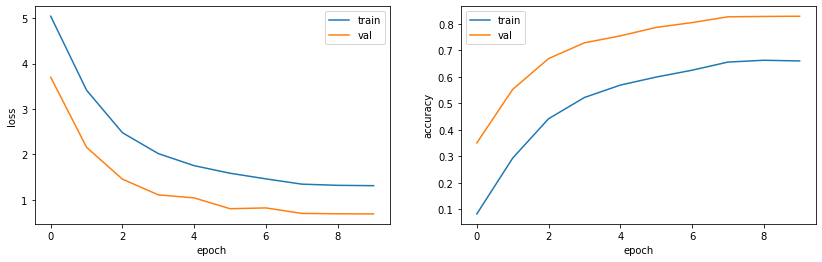

In [27]:
show_results(train_losses, val_losses, train_accuracies, val_accuracies)